# Persistent Homology using Ripser
- Input: embedding (downsampled or raw) pickle file 
    - stored as a dict (name: model, embedding)
- Output: dgms (list of np arrays per dimension/homology group rank)

notes:
- stimulus key: cex=color exchange, dg=drifting gratings, cg=chromatic gratings, lf=luminance flash

Author: @emilyekstrum
<br> 11/26/25

In [10]:
#load modules
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from ripser import ripser
import random
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from persim import plot_diagrams
import seaborn as sns
import os

In [11]:
# Import TDA utilities
import sys
from pathlib import Path

# Add the repo root to path if needed
repo_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

try:
    from tda_utils import TDADataManager, tda_manager
    print("TDA utilities loaded")
except ImportError as e:
    print(f"Could not import TDA utilities: {e}")
    print("Make sure you're running from the TDA repository.")
    raise

# Initialize or use the global data manager
if tda_manager is not None:
    data_manager = tda_manager
else:
    data_manager = TDADataManager()

# Print summary of available data
data_manager.print_summary()

TDA utilities loaded
TDA Data Manager Summary
Workspace root: /Users/emilyekstrum/repos/TDA
Data directory: /Users/emilyekstrum/repos/TDA/data
  - clean_spike_data_zip: clean_spike_data.zip
  - clean_spike_data_dir: clean_spike_data
      Contains 8 .pkl files
  - cebra_examples: CEBRA_embedding_examples
      Contains 4 .pkl files
  - persistence_examples: persistence_diagram_examples
      Contains 22 .pkl files

Available spike datasets (8):
  • LGNchromatic_gratings.pkl
  • LGNcolor_exchange.pkl
  • LGNdrifting_gratings.pkl
  • LGNluminance_flash.pkl
  • V1chromatic_gratings.pkl
  and 3 more


In [ ]:
#utils
# RUN ME

#randomly downsample embeddings
def downsample_embedding(embed, n_target=1000, seed=42): 
    """Downsamples embedding to n_target points using random sampling without replacement.
    Args:
        embed : np.ndarray of shape (N, D) where N is number of points and D is embedding dimension.
        n_target : int, target number of points after downsampling.
    Returns:
        downsampled_embed : np.ndarray of shape (n_target, D) if N > n_target, else original embed."""
    
    embed = np.asarray(embed, dtype=np.float32)
    N = embed.shape[0]
    if N <= n_target:
        return embed
    rng = np.random.default_rng(seed)
    idx = rng.choice(N, size=n_target, replace=False)
    print("Downsampling done")
    return embed[idx]

# farthest point sampling (FPS) downsample embeddings
def fps_downsample_embedding(embed, n_target=1000, method="fps", seed=42):
    """Downsamples embedding to n_target points using either random sampling or Farthest Point Sampling (FPS).
    Args:
        embed : np.ndarray of shape (N, D) where N is number of points and D is embedding dimension.
        n_target : int, target number of points after downsampling.
        method : str, either "random" or "fps" to specify downsampling method.
    Returns:
        downsampled_embed : np.ndarray of shape (n_target, D) if N > n_target, else original embed."""
    
    N = embed.shape[0]
    print(N)
    if n_target >= N:
        return embed  
    
    rng = np.random.default_rng(seed)

    if method == "random":
        idx = rng.choice(N, size=n_target, replace=False)
        return embed[idx]

    elif method == "fps":
        idxs = [rng.integers(N)]
        dists = np.linalg.norm(embed - embed[idxs[0]], axis=1)

        for _ in range(1, n_target):
            next_idx = np.argmax(dists)
            idxs.append(next_idx)
            new_dists = np.linalg.norm(embed - embed[next_idx], axis=1)
            dists = np.minimum(dists, new_dists)

        return embed[idxs]

    else:
        raise ValueError("method must be 'random' or 'fps'")
    

# embedding to KNN sparse matrix
def knn_sparse_dist(embedding, n_neighbors=300, metric="euclidean", plot = False, plot_title= " "):
    """Makes symmetric KNN sparse distance matrix -> input for ripser
       Can also plot heatmap of distance matrix subset
       
    Args:
        embedding : np.ndarray of shape (N, D) where N is number of points and D is embedding dimension.
        n_neighbors : int, number of nearest neighbors to consider for each point.
        metric : str, distance metric to use (default is "euclidean").
        plot : bool, whether to plot heatmap of distance matrix subset.
        plot_title : str, title for the heatmap plot.
    Returns:
        sparse_matrix : scipy.sparse.csr_matrix of shape (N, N) representing the symmetric KNN distance matrix."""
    
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, n_jobs=-1)
    nn.fit(embedding)
    distances, indices = nn.kneighbors(embedding, return_distance=True)        
    num_samples = embedding.shape[0]
    rows = np.repeat(np.arange(num_samples), n_neighbors)
    cols = indices.ravel()
    vals = distances.ravel().astype(np.float32)

    sparse_matrix = csr_matrix((vals, (rows, cols)), shape=(num_samples, num_samples))
    # Symmetrize with min distance on shared edges
    sparse_matrix = sparse_matrix.minimum(sparse_matrix.transpose())

    if plot == True:
        m = min(600, sparse_matrix.shape[0])
        dense_sub = sparse_matrix[:m, :m]
        mask_sub = (dense_sub == 0)

        sns.heatmap(dense_sub, mask=mask_sub, cmap='viridis', square=True, cbar_kws ={'label' : 'Distance'})
        plt.title(plot_title)
        plt.show()
    return sparse_matrix


# ripser - TDA persistent homology heavy lifting
def tda_ripser(distance_matrix, name, maxdim=2, region='LGN', dims=3, stim = "cex", embed_type = "CEBRA", plot = False):
    """ Computes persistence diagrams and optionally plots them.
    
    Args:
        distance_matrix : np.ndarray or scipy.sparse matrix representing the distance matrix.
        name : str, name of the dataset/session.
        maxdim : int, maximum homology dimension to compute (default is 2).
        region : str, brain region (default is 'LGN').
        dims : int, embedding dimension (default is 3).
        stim : str, stimulus type (default is "cex").
        embed_type : str, type of embedding (default is "CEBRA").
        plot : bool, whether to plot the persistence diagrams (default is False).
    Returns:
        dgms : list of np.ndarray, persistence diagrams for each homology dimension."""

    dgms = ripser(distance_matrix, distance_matrix=True, maxdim=maxdim)['dgms']

    if plot == True:
        plot_diagrams(dgms, title=(f"Persistence Diagram of {name} - {stim}"), show=True)
    
    return dgms

In [ ]:
# find and list available CEBRA embedding files
available_embeddings = data_manager.find_files("*.pkl", "cebra_examples")

if available_embeddings:
    print(f"{len(available_embeddings)} CEBRA embedding files:")
    for i, path in enumerate(available_embeddings, 1):
        # parse filename info
        info = data_manager.parse_filename_info(path)
        print(f"  {i}. {path.name}")
        print(f"     Region: {info['region']}, Dimension: {info['dimension']}, Stimulus: {info['stimulus']}")
    
    print(f"\nTo process a specific file, set 'selected_embedding_index' below (1-{len(available_embeddings)})")
else:
    print("No CEBRA embedding files found.")
    print("Run the CEBRA embeddings notebook first to generate embeddings.")

4 CEBRA embedding files:
  1. V1_3d_CEBRA_unsup_time_color_exchange.pkl
     Region: V1, Dimension: 3d, Stimulus: color_exchange
  2. V1_8d_CEBRA_unsup_time_color_exchange.pkl
     Region: V1, Dimension: 8d, Stimulus: color_exchange
  3. LGN_3d_CEBRA_unsup_time_color_exchange.pkl
     Region: LGN, Dimension: 3d, Stimulus: color_exchange
  4. LGN_8d_CEBRA_unsup_time_color_exchange.pkl
     Region: LGN, Dimension: 8d, Stimulus: color_exchange

To process a specific file, set 'selected_embedding_index' below (1-4)


In [ ]:
# get embedding to process
if available_embeddings:
    # config
    selected_embedding_index = 1  # change this to select a different file (1-based index)
    
    # select the first available embedding if index is out of range
    if selected_embedding_index < 1 or selected_embedding_index > len(available_embeddings):
        selected_embedding_index = 1
        print(f"Index out of range, using first available embedding")
    
    # get the selected embedding
    selected_embedding_path = available_embeddings[selected_embedding_index - 1]
    embedding_info = data_manager.parse_filename_info(selected_embedding_path)
    
    print(f"Selected: {selected_embedding_path.name}")
    print(f"Metadata: {embedding_info}")
    
    # parameters (from filename or use defaults)
    embed_type = "CEBRA"
    dims = int(embedding_info['dimension'].replace('d', '')) if embedding_info['dimension'] != 'unknown' else 3
    region = embedding_info['region'] if embedding_info['region'] != 'unknown' else "LGN"
    stim = embedding_info['stimulus'] if embedding_info['stimulus'] != 'unknown' else "cex"
    maxdim = 2 # homology groups - *note* increasing this significantly increases computation time

    #KNN matrix parameters
    n_neighbors = 300 
    matrix_metric = 'cosine'
    plot_matrix = False
    matrix_plot_title = f"{region} {stim} - Distance Matrix"

    #Ripser parameters
    plot_dgms = True # to plot persistence diagram
    
    print(f"\nParams:")
    print(f"  Embedding type: {embed_type}")
    print(f"  Dimensions: {dims}d")
    print(f"  Region: {region}")
    print(f"  Stimulus: {stim}")
    print(f"  Max homology dimension: {maxdim}")


Selected: V1_3d_CEBRA_unsup_time_color_exchange.pkl
Metadata: {'region': 'V1', 'dimension': '3d', 'stimulus': 'color_exchange', 'mouse_id': 'unknown', 'is_shuffled': False, 'is_random': False, 'filename': 'V1_3d_CEBRA_unsup_time_color_exchange.pkl', 'stem': 'V1_3d_CEBRA_unsup_time_color_exchange'}

Params:
  Embedding type: CEBRA
  Dimensions: 3d
  Region: V1
  Stimulus: color_exchange
  Max homology dimension: 2


Loading model: Using CPU
CUDA compatibility issue detected, forcing CPU mapping
Successfully loaded using custom CPU unpickler
Moving d4 model from cuda:0 to cpu
Loaded embedding with sessions: ['d4', 'd5', 'd6', 'C153', 'C155', 'C159', 'C160', 'C161']

Session: d4
  Original embedding shape: (34000, 3)
  Downsampling from 34000 to 10000 points...
34000


/opt/anaconda3/lib/python3.13/site-packages/torch/_weights_only_unpickler.py:552: UserWarning: Detected pickle protocol 4 in the checkpoint, which was not the default pickle protocol used by `torch.load` (2). The weights_only Unpickler might not support all instructions implemented by this protocol, please file an issue for adding support if you encounter this.
  warnings.warn(


  Creating cosine distance matrix with k=300
  Computing persistence diagrams (max dimension 2)


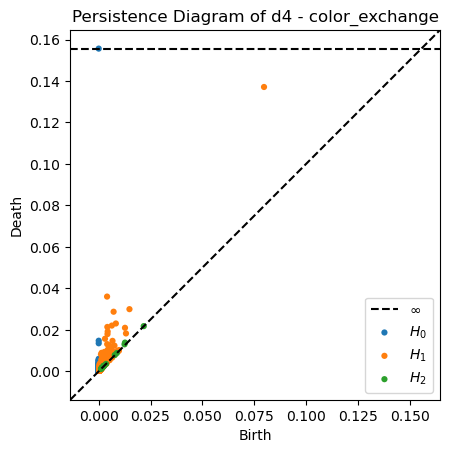

    H0: 10000 features
    H1: 4662 features
    H2: 21 features

Session: d5
  Original embedding shape: (34000, 3)
  Downsampling from 34000 to 10000 points...
34000
  Creating cosine distance matrix with k=300
  Computing persistence diagrams (max dimension 2)


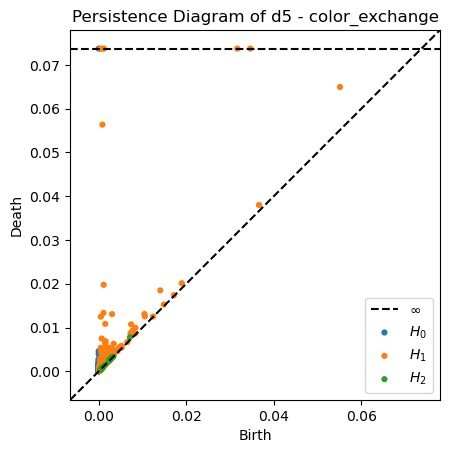

    H0: 10000 features
    H1: 4007 features
    H2: 22 features

Session: d6
  Original embedding shape: (34000, 3)
  Downsampling from 34000 to 10000 points...
34000
  Creating cosine distance matrix with k=300
  Computing persistence diagrams (max dimension 2)


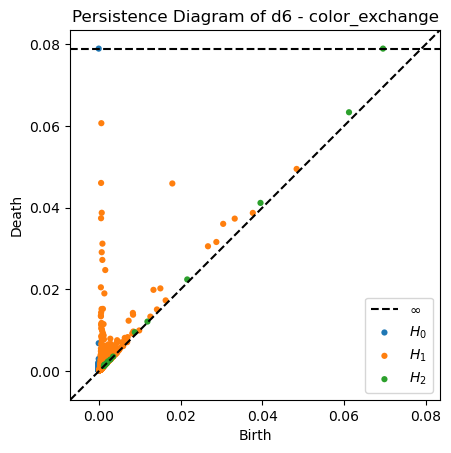

    H0: 10000 features
    H1: 4358 features
    H2: 18 features

Session: C153
  Original embedding shape: (34000, 3)
  Downsampling from 34000 to 10000 points...
34000
  Creating cosine distance matrix with k=300
  Computing persistence diagrams (max dimension 2)


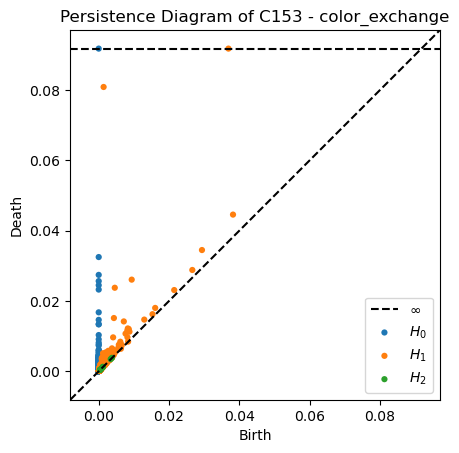

    H0: 10000 features
    H1: 4279 features
    H2: 12 features

Session: C155
  Original embedding shape: (34000, 3)
  Downsampling from 34000 to 10000 points...
34000
  Creating cosine distance matrix with k=300
  Computing persistence diagrams (max dimension 2)


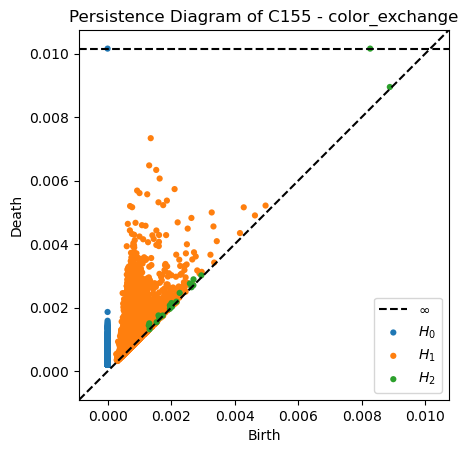

    H0: 10000 features
    H1: 4567 features
    H2: 21 features

Session: C159
  Original embedding shape: (34000, 3)
  Downsampling from 34000 to 10000 points...
34000
  Creating cosine distance matrix with k=300
  Computing persistence diagrams (max dimension 2)


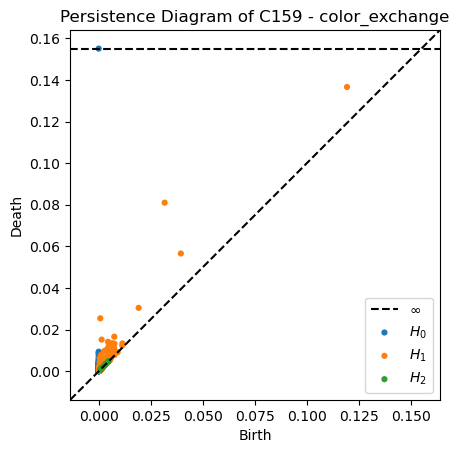

    H0: 10000 features
    H1: 4408 features
    H2: 23 features

Session: C160
  Original embedding shape: (34000, 3)
  Downsampling from 34000 to 10000 points...
34000
  Creating cosine distance matrix with k=300
  Computing persistence diagrams (max dimension 2)


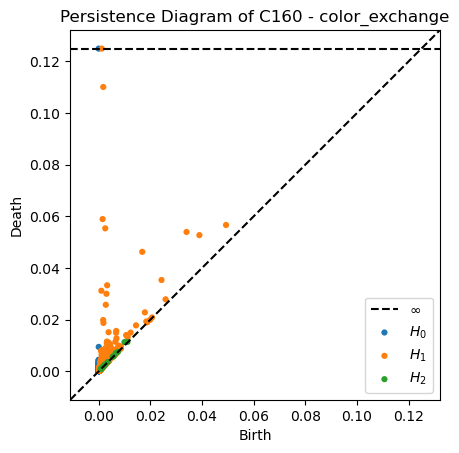

    H0: 10000 features
    H1: 4338 features
    H2: 22 features

Session: C161
  Original embedding shape: (34000, 3)
  Downsampling from 34000 to 10000 points...
34000
  Creating cosine distance matrix with k=300
  Computing persistence diagrams (max dimension 2)


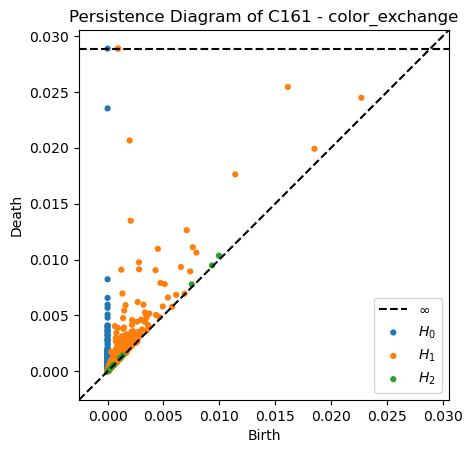

    H0: 10000 features
    H1: 3600 features
    H2: 11 features

Processing complete for all 8 sessions


In [ ]:
# process an embedding
if available_embeddings:
    try:
        # load embedding data
        session_dict, session_names = data_manager.load_embedding_data(selected_embedding_path)
        print(f"Loaded embedding with sessions: {session_names}")
        
        # process each session
        all_dgms = {}
        
        for session_name in session_names:
            print(f"\nSession: {session_name}")
            
            # get the embedding for session
            embedding = session_dict[session_name]['embedding']
            print(f"  Original embedding shape: {embedding.shape}")
            
            # downsample if needed (recommend)
            if embedding.shape[0] > 10000:
                print(f"  Downsampling from {embedding.shape[0]} to 10000 points...")
                ds_embedding = fps_downsample_embedding(embedding, n_target=10000)
            else:
                ds_embedding = embedding
                print(f"  Using full embedding ({embedding.shape[0]} points)")
            
            # create KNN sparse matrix
            print(f"  Creating {matrix_metric} distance matrix with k={n_neighbors}")
            sparse_matrix = knn_sparse_dist(ds_embedding, n_neighbors, matrix_metric, plot_matrix, matrix_plot_title)
            
            # compute persistence diagrams
            print(f"  Computing persistence diagrams (max dimension {maxdim})")
            dgms = tda_ripser(sparse_matrix, session_name, maxdim, region, dims, stim, embed_type, plot=plot_dgms)
            
            # store results
            all_dgms[session_name] = dgms
            
            # show some stats
            for i, dgm in enumerate(dgms):
                if dgm is not None and len(dgm) > 0:
                    print(f"    H{i}: {len(dgm)} features")
                else:
                    print(f"    H{i}: 0 features")
        
        print(f"\nProcessing complete for all {len(session_names)} sessions")
        
    except Exception as e:
        print(f"Error processing embedding: {e}")
        import traceback
        traceback.print_exc()

In [ ]:
# save persistence diagrams using dgms metadata
if available_embeddings and 'all_dgms' in locals() and all_dgms:
    try:
        for session_name, dgms in all_dgms.items():
            # filename
            filename_parts = [embed_type, f"{dims}d", region, stim, session_name]
            output_filename = "_".join(filename_parts) + ".pkl"
            
            # save to persistence examples directory
            output_path = data_manager.get_output_path(output_filename, 'persistence_diagram_examples')
            
            print(f"Saving {session_name} persistence diagrams to: {output_path.name}")
            
            with open(output_path, 'wb') as f:
                pkl.dump(dgms, f)
        
        print(f"\nAll persistence diagrams saved")
        print(f"Location: {data_manager.data_paths['persistence_examples']}")
        
    except Exception as e:
        print(f"Error saving results: {e}")
        import traceback
        traceback.print_exc()

Saving d4 persistence diagrams to: CEBRA_3d_V1_color_exchange_d4.pkl
Saving d5 persistence diagrams to: CEBRA_3d_V1_color_exchange_d5.pkl
Saving d6 persistence diagrams to: CEBRA_3d_V1_color_exchange_d6.pkl
Saving C153 persistence diagrams to: CEBRA_3d_V1_color_exchange_C153.pkl
Saving C155 persistence diagrams to: CEBRA_3d_V1_color_exchange_C155.pkl
Saving C159 persistence diagrams to: CEBRA_3d_V1_color_exchange_C159.pkl
Saving C160 persistence diagrams to: CEBRA_3d_V1_color_exchange_C160.pkl
Saving C161 persistence diagrams to: CEBRA_3d_V1_color_exchange_C161.pkl

All persistence diagrams saved
Location: /Users/emilyekstrum/repos/TDA/data/persistence_diagram_examples


# Manual Configuration 
- to manually specify paths and parameters, use the cells below:

In [ ]:
# manual configuration - specify parameters
# run this if you want to override the params above

manual_mode = False  # Set to True to use manual config

if manual_mode:
    # get available embedding files
    cebra_files = data_manager.find_files("*.pkl", "cebra_examples")
    
    if cebra_files:
        # select a specific file by name pattern
        embedding_path = None
        target_pattern = "LGN_3d_CEBRA"  # change this to match file
        
        for file_path in cebra_files:
            if target_pattern.lower() in file_path.name.lower():
                embedding_path = file_path
                break
        
        if embedding_path:
            print(f"Found file: {embedding_path.name}")
            
            # manual parameters
            embed_type = "CEBRA"
            session_names_to_process = ["C153"]  # specify which sessions/mouse ID to process
            dims = 3
            stim = "cex"
            maxdim = 2
            region = "LGN"
            
            # process with manual settings
            session_dict = pd.read_pickle(embedding_path)
            print(f"Available sessions: {list(session_dict.keys())}")
            
        else:
            print(f"No file matching pattern '{target_pattern}' found")
    else:
        print("No CEBRA embedding files found")

22 saved persistence diagram files:
  1. CEBRA_3d_V1_color_exchange_d6.pkl
  2. CEBRA_3d_V1_color_exchange_C159.pkl
  3. CEBRA_3d_V1_color_exchange_d5.pkl
  4. CEBRA_3d_V1_color_exchange_d4.pkl
  5. CEBRA_3d_LGN_cex_C159.pkl

Testing: CEBRA_3d_LGN_cex_C159.pkl
3 homology dimensions
  H0: 10000 persistence features
  H1: 4180 persistence features
  H2: 15 persistence features


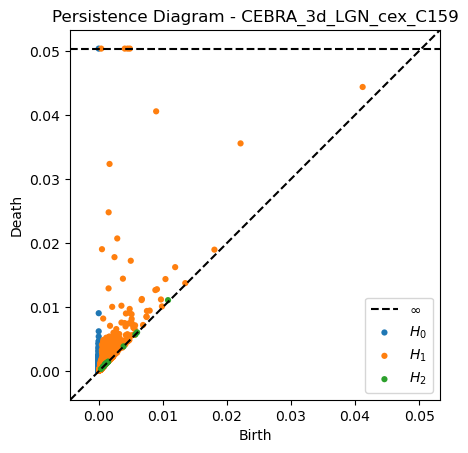

In [9]:
# plot saved persistence diagrams
saved_dgms = data_manager.find_files("*.pkl", "persistence_examples")

if saved_dgms:
    print(f"{len(saved_dgms)} saved persistence diagram files:")
    for i, path in enumerate(saved_dgms[-5:], 1):  # show last 5
        print(f"  {i}. {path.name}")
    
    # test loading one of them
    if saved_dgms:
        test_path = saved_dgms[-1]  # use the most recent one or change to another index
        print(f"\nTesting: {test_path.name}")
        
        try:
            test_dgms = data_manager.load_persistence_diagrams(test_path)
            print(f"{len(test_dgms)} homology dimensions")
            for i, dgm in enumerate(test_dgms):
                if dgm is not None and len(dgm) > 0:
                    print(f"  H{i}: {len(dgm)} persistence features")
                else:
                    print(f"  H{i}: 0 features")
            
            # optionally plot the persistence diagram
            plot_test_dgm = True
            if plot_test_dgm:
                plot_diagrams(test_dgms, title=f"Persistence Diagram - {test_path.stem}", show=True)
            
        except Exception as e:
            print(f"Error loading test file: {e}")
else:
    print("No persistence diagram files found.")
    print("Run the processing cells above to generate them.")